In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from loaddatastructs import *
from helperfuncs import *
from plottingfuncs import *
import matplotlib.patches as mpatches


In [2]:
Archive.archive_path = '/data/nriemer/d/sf20/les_output/wrf-partmc'
Archive.gridsize = 100

Archive.addScenario(scenario_name='uniform-basecase', slurm_id=1984671)
Archive.addScenario(scenario_name='fx1fy0', slurm_id=1996526)
Archive.addScenario(scenario_name='road-10x', slurm_id=1996525)
Archive.addScenario(scenario_name='point-source-1x1', slurm_id=1984672)

# Scenarios to evaluate ccn activity in complete absence of ammonia
#Archive.addScenario(scenario_name='uniform-basecase-no-nh4', slurm_id=2008005)
#Archive.addScenario(scenario_name='point-source-1x1-no-nh4', slurm_id=2008006)

In [4]:
def plotVarCrossSections(scenario, var, time_idxs=[1, 5, 10, 20], z_idx=1, var_range=None, title='', time_units='h', 
                        show_sh=False, savefig=False,):

    suptitle_fontsize=17
    subplot_title_fontsize=15
    colorbar_label_fontsize=13
    colorbar_title_fontsize=14

    data = Archive.aero_data[scenario]
    plt.rcParams['image.cmap'] = 'plasma'
    var_data = data[var] 

    global_min = var_range[0]
    global_max = var_range[1]

    n_rows = 1
    n_cols = len(time_idxs)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,4*n_rows), 
                           subplot_kw=dict(box_aspect=1), sharex=True, sharey=True, layout="constrained")
    for i, time_idx in enumerate(time_idxs):
        time_min = time_idx*Archive.historydelta_m
        var_plane_data = 1000*var_data[time_idx].data[z_idx, :, :] # convert to ppbv
        var_units = 'ppbv'
        if var =='oh':
            var_plane_data *= 1000 # convert to pptv 
            var_units = 'pptv'
        
        # Coerce values outside of colorbar range to lie within
        var_plane_data_masked = np.where(var_plane_data < global_min, global_min, var_plane_data)
        var_plane_data_masked = np.where(var_plane_data_masked > global_max, global_max, var_plane_data_masked)

        if global_max/global_min > 10:
            norm = matplotlib.colors.LogNorm(vmin=global_min, vmax=global_max)
        else:
            norm = matplotlib.colors.Normalize(vmin=global_min, vmax=global_max)

        c1 = ax[i].pcolormesh(var_plane_data, norm=norm,edgecolor='face')

        if time_units == 'h':
            time =  time_idx*Archive.historydelta_m / 60

        if time_units == 'm':
            time =  time_idx*Archive.historydelta_m

        ax[i].text( .5, 1.05, f'$t = {time:2.0f}$ {time_units}', size=subplot_title_fontsize, 
                   horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes)
        ax[i].axes.get_yaxis().set_visible(False)
        ax[i].axes.get_xaxis().set_visible(False)

        if show_sh:
            SH = mcnormspatialhet(var_plane_data, n_permutes=40000)
            #SH = mc_sh.mcspatialhet(var_plane_data/var_plane_data.max(), n_permutes=50000, n_estimates=1, replacement=True) 
            t = ax[i].text(50, 10, f'$SH={SH:3.2f}$', horizontalalignment='center', verticalalignment='center', size=20)
            t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='k'))

    #ax[0].set_title('O$_3$', size=15, y=0.5, x=-.2, verticalalignment='center')
    cbar1 = fig.colorbar(c1, ax=ax[-1], )#format='%1.e')
    cbar1.ax.tick_params(labelsize=colorbar_label_fontsize)

    variable_fmt = Archive.gas_fmt_map[var]
    cbar1.ax.set_title(f'{variable_fmt} ({var_units})', fontsize=colorbar_title_fontsize, loc='left', pad=10)

    plt.suptitle(title, fontsize=suptitle_fontsize, x=0.47)
    #time_min = time_idx*time_spacing
    #fig.suptitle(f'Time = {time_min:2.0f} mins, Z-level = {z_idx:2.0f}', size=15)

    if savefig:
        plt.savefig(f"{var}-crosssec-{scenario}-z{z_idx}.pdf", format='pdf', bbox_inches='tight')

def calculate_Is(data, species_A, species_B, time_i, z_level):

    A_data = data[species_A][time_i].data[z_level, :, :]

    if species_B == 'nox':
        B_data = data['no2'][time_i].data[z_level, :, :] + data['no'][time_i].data[z_level, :, :]   
    else:
        B_data = data[species_B][time_i].data[z_level, :, :]

    # Calculate the covariance (need to flatten the 2d fields to 1d!)
    cov = np.cov(A_data.flatten(), B_data.flatten())

    # Print the covariance
    #print(cov)
    cov_AB = cov[0, 1]
    Is = cov_AB / (A_data.mean()*B_data.mean())

    return Is

def plotSegregationIntensity(scenario, species_A, species_B, z_level, savefig=False, **kwargs):

    data = Archive.aero_data[scenario]

    n_times = Archive.n_times
    historydelta_m = Archive.historydelta_m
    times = np.arange(0, n_times*historydelta_m, historydelta_m)

    Is_profile = []

    for time_i in range(n_times):

        Is = calculate_Is(data, species_A, species_B, time_i=time_i, z_level=z_level)
        #print(Is)
        Is_profile.append(Is)

    idx = np.isfinite(Is_profile) # the first entry may be nan since div by zero if concentrations are zero

    fig, ax = plt.subplots(1,1, figsize=(8, 6))
    Is_profile = np.array(Is_profile)
    ax.plot(times[idx], Is_profile[idx], lw=2, c='k')
    ax.axhspan(0, 100, color='#A7C5F9', alpha=.5)
    ax.text(1.02, 1, 'Positive\ncovariance', ha='left', va='center', c='#1545CF', fontsize=16, transform=ax.transAxes)
    ax.axhline(0, linestyle='--', c='#5A5A5A', lw=2)
    ax.axhspan(-1, 0, color='#ea9999', alpha=.5)
    ax.axhline(-1, linestyle='-', c='#e06666')
    ax.text(1.02, .0, 'Segregated', ha='left', va='center', c='#cc0000', fontsize=16, transform=ax.transAxes)
    #ax.text(210, -.83, 'Fully\nsegregated', ha='center', va='center', c='#cc0000', fontsize=11)
    ax.set_ylabel('$I_s$', fontsize=15)
    ax.set_xlabel('Time (mins)',  fontsize=15)

    ylims = kwargs.get('ylims', (-1, 1.15))
    center_text_y_pos = 1/(abs(ylims[0])+ylims[1])
    ax.text(1.02, center_text_y_pos, 'Fully mixed', ha='left', va='center', c='k', fontsize=16, transform=ax.transAxes)

    ax.set_ylim(ylims[0], ylims[1])
    ax.set_xlim(times[0], times[-1])

    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,5), c='#414141')
    ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,5), c='#414141')
    ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,5), c='#414141')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%3.0f'))
    ax.tick_params(axis='both', which='major', labelsize=13, direction='in', top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)
    if savefig:
        plt.savefig(f'segreg-intens-{scenario}-zlevel{z_level}.pdf', format='pdf', bbox_inches='tight')


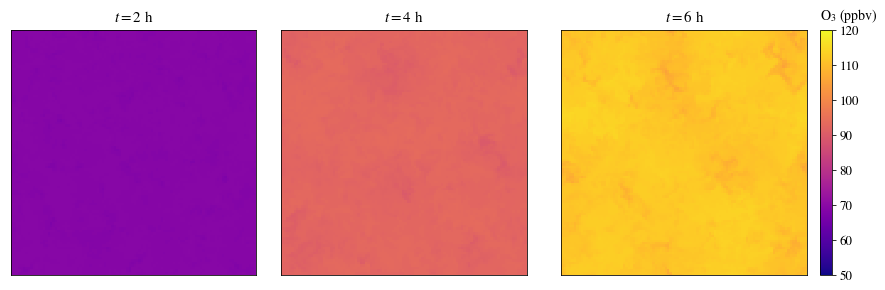

In [5]:
plotVarCrossSections(scenario='uniform-basecase', var='o3', time_idxs=[12, 24, 36], z_idx=25, var_range=(50, 120), time_units='h',
                     savefig=True)

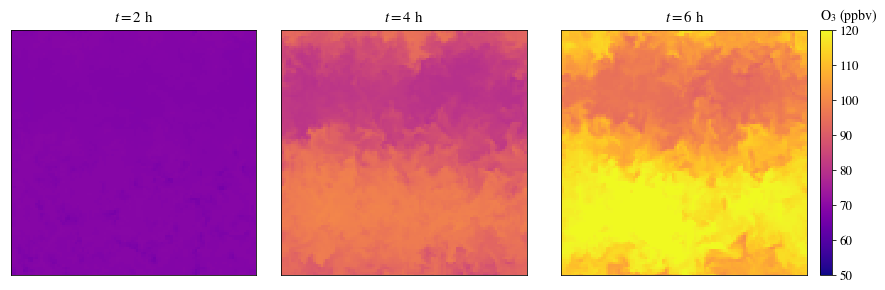

In [6]:
plotVarCrossSections(scenario='fx1fy0', var='o3', time_idxs=[12, 24, 36], z_idx=25, var_range=(50, 120), time_units='h', 
                     savefig=True)

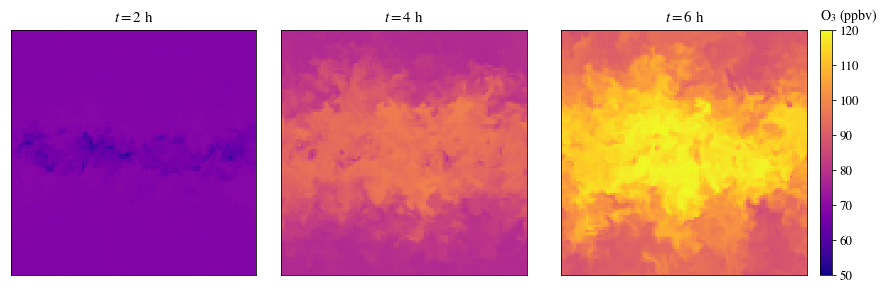

In [7]:
plotVarCrossSections(scenario='road-10x', var='o3', time_idxs=[12, 24, 36], z_idx=25, var_range=(50, 120), time_units='h',
                     savefig=True)

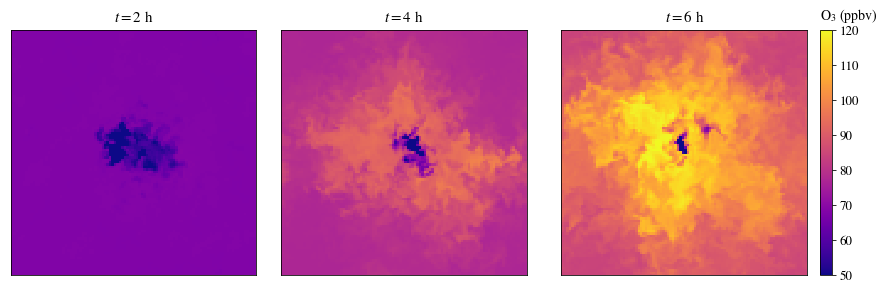

In [8]:
plotVarCrossSections(scenario='point-source-1x1', var='o3', time_idxs=[12, 24, 36], z_idx=25, var_range=(50, 120), time_units='h',
                     show_sh=False, savefig=True)

In [60]:
data = 1000*Archive.aero_data['point-source-1x1']['oh'][36, 25, :, :]

In [62]:
data.max()

0.0007191487

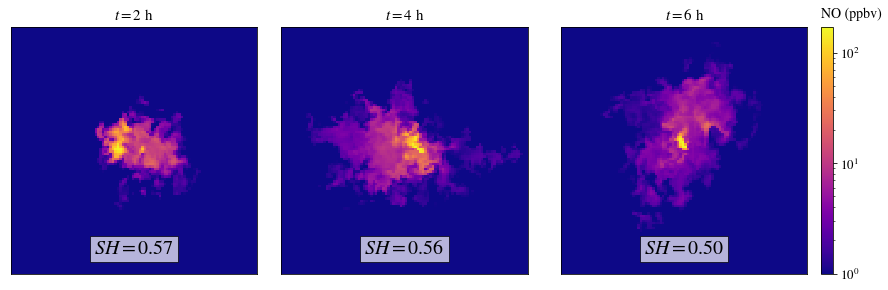

In [80]:
plotVarCrossSections(scenario='point-source-1x1', var='no', time_idxs=[12, 24, 36], z_idx=25, var_range=(1, 170),
show_sh=True)

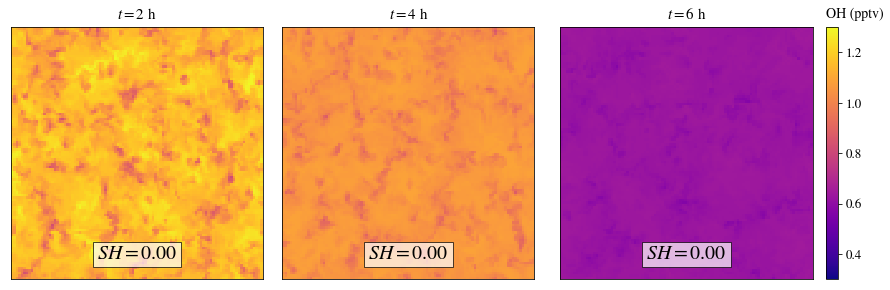

In [90]:
plotVarCrossSections(scenario='uniform-basecase', var='oh', time_idxs=[12, 24, 36], z_idx=25, var_range=(.3, 1.3),
show_sh=True)

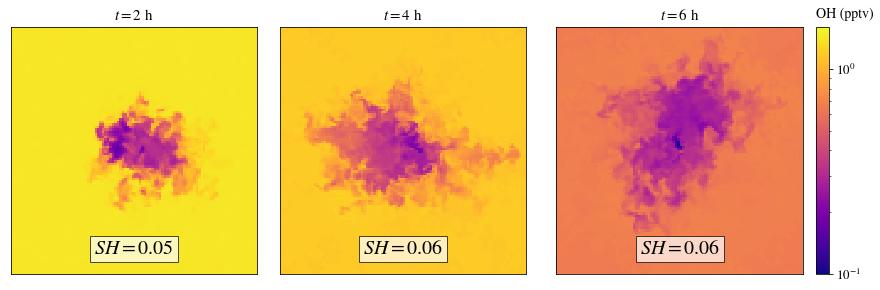

In [96]:
plotVarCrossSections(scenario='point-source-1x1', var='oh', time_idxs=[12, 24, 36], z_idx=25, var_range=(.1, 1.6),
show_sh=True)

In [11]:
data = Archive.aero_data['uniform-basecase']

In very polluted regions (such as the high emissions heterogeneity cases), NOx titration occurs whereby ozone is removed by reacting with NO:
$NO + O3 \rarr NO2 + O2$
It then makes sense that the NO2 levels are higher in the high heterogeneity cases, as this removal mechanism for ozone is converting the ozone and NO into NO2.

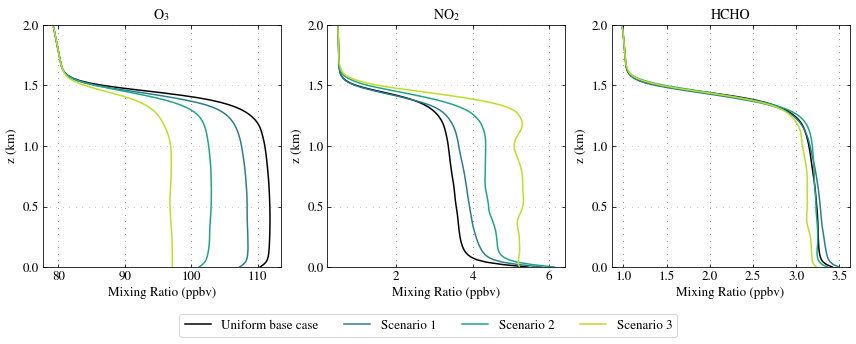

In [5]:
plotScenariosVarsVerticalProfile(scenarios=['uniform-basecase', 'fx1fy0', 'road-10x', 'point-source-1x1'], 
                                 variables=['o3', 'no2', 'hcho'], time=36, title='',
                                 general_scenario_label=True, use_standard_scenario_colors=True, savefig=True)

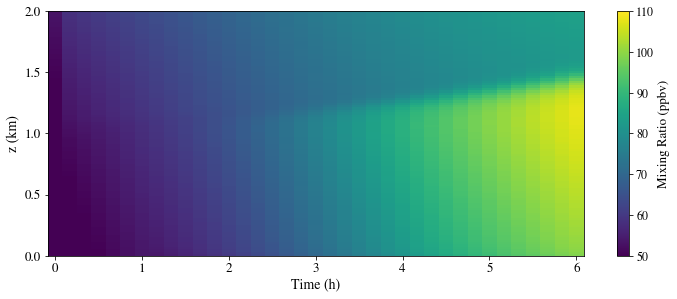

In [4]:
plotZT(scenario='uniform-basecase', variable='o3', vmin=50, vmax=110, lognorm=False,
       xtick_delta_t=1, xtick_units='h', title='', savefig=True
       )

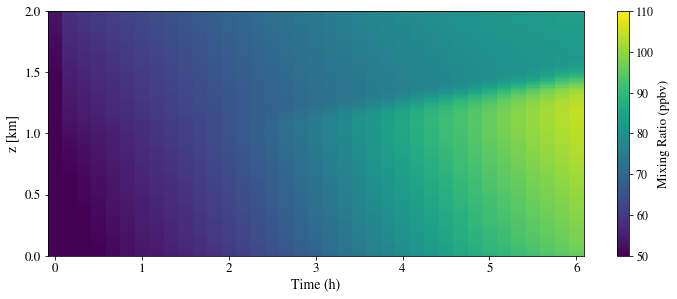

In [4]:
plotZT(scenario='fx1fy0', variable='o3', vmin=50, vmax=110, lognorm=False,
       xtick_delta_t=1, xtick_units='h', title='', savefig=True
       )

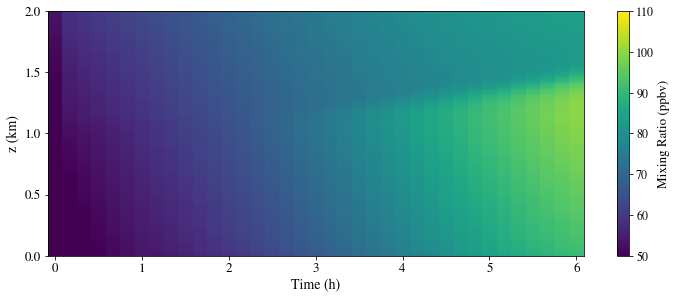

In [5]:
plotZT(scenario='road-10x', variable='o3', vmin=50, vmax=110, lognorm=False,
       xtick_delta_t=1, xtick_units='h', title='', savefig=True
       )

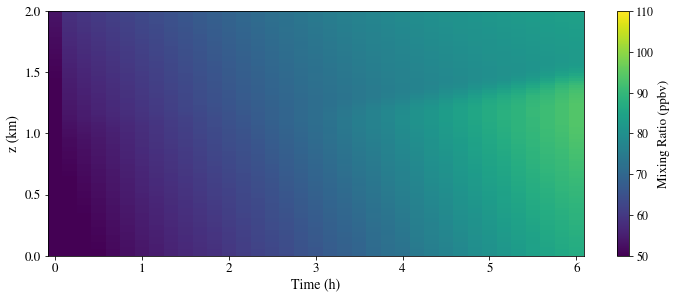

In [6]:
plotZT(scenario='point-source-1x1', variable='o3', vmin=50, vmax=110, lognorm=False,
       xtick_delta_t=1, xtick_units='h', title='', savefig=True
       )

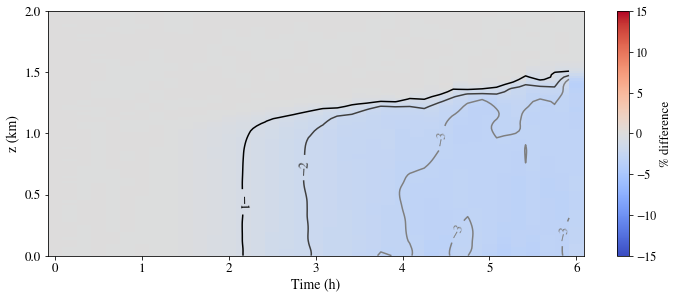

In [9]:
plotVarPercentDiff(scenario='fx1fy0', variable='o3', vmin=-15, vmax=15, 
                    xtick_delta_t=1, xtick_units='h', title='',
                    plot_contours=True,n_contours=6, contour_min=-5, contour_max=0,
                    savefig=True)


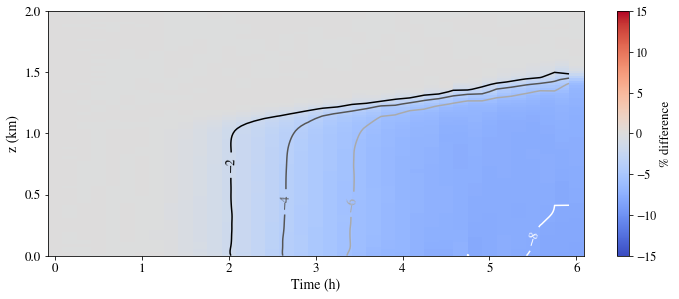

In [10]:
plotVarPercentDiff(scenario='road-10x', variable='o3', vmin=-15, vmax=15, xtick_delta_t=1, xtick_units='h', title='',
                   plot_contours=True,n_contours=5, contour_min=-8, contour_max=0,
                   savefig=True)

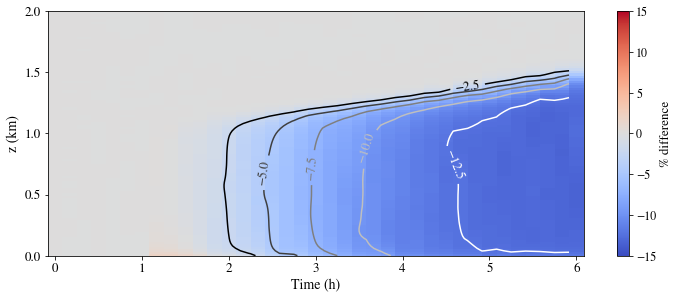

In [11]:
plotVarPercentDiff(scenario='point-source-1x1', variable='o3', vmin=-15, vmax=15, xtick_delta_t=1, xtick_units='h', title='',
                   plot_contours=True,n_contours=6, contour_min=-12.5, contour_max=0,
                   savefig=True)

These segregation intensity plots show that as the spatial heterogeneity of emissions increases, O3 and NO2 are more spatially segregated, especially during hours 2-4. Overall this reduces the effective rate of ozone removal by the O3 + NO2 -> NO3 pathway

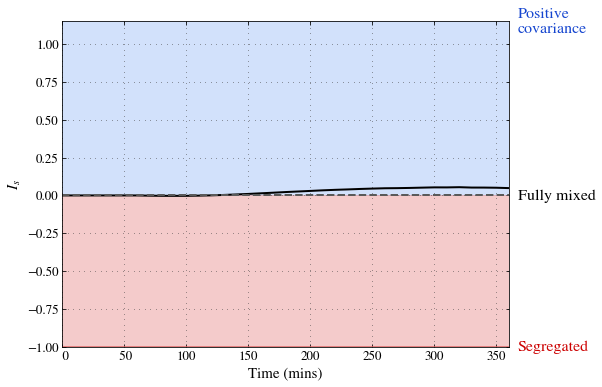

In [71]:
plotSegregationIntensity(scenario='fx1fy0', species_A='o3', species_B='no2', z_level=25, savefig=False)

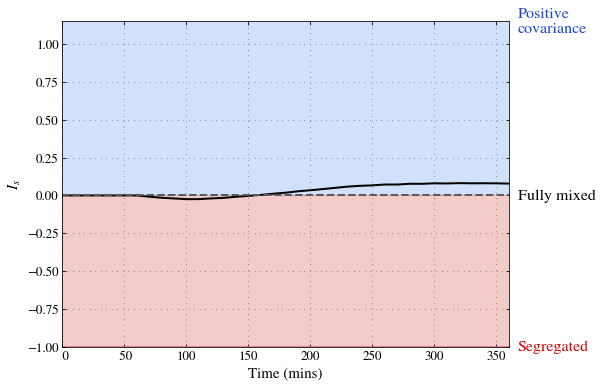

In [72]:
plotSegregationIntensity(scenario='road-10x', species_A='o3', species_B='no2', z_level=25, savefig=False)

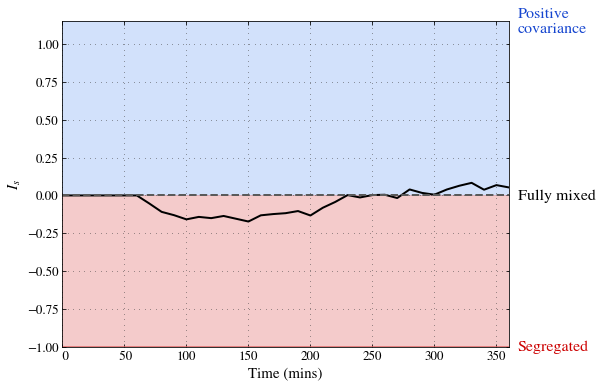

In [97]:
plotSegregationIntensity(scenario='point-source-1x1', species_A='o3', species_B='no2', z_level=25, savefig=False)

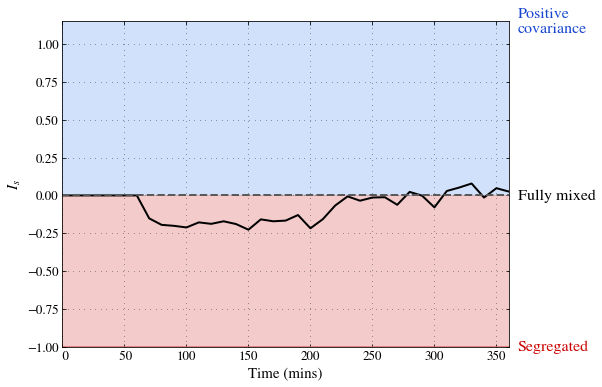

In [81]:
plotSegregationIntensity(scenario='point-source-1x1', species_A='o3', species_B='nox', z_level=25, savefig=False)

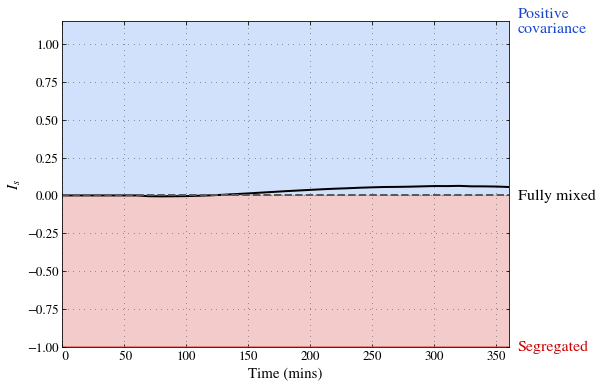

In [85]:
plotSegregationIntensity(scenario='fx1fy0', species_A='o3', species_B='eth', z_level=25, savefig=False)

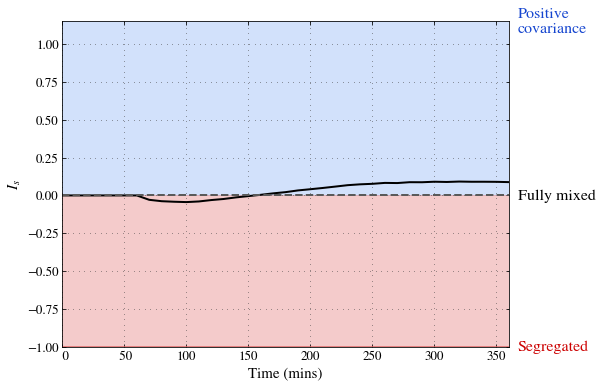

In [86]:
plotSegregationIntensity(scenario='road-10x', species_A='o3', species_B='eth', z_level=25, savefig=False)

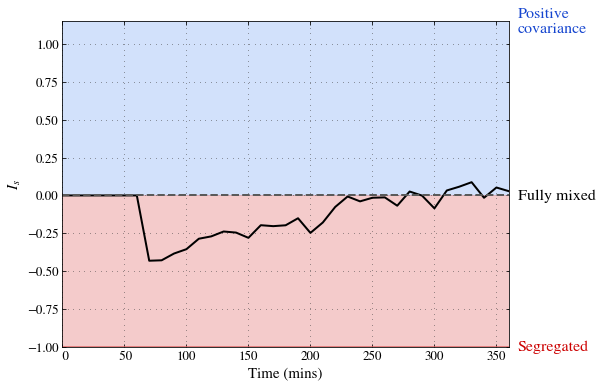

In [95]:
plotSegregationIntensity(scenario='point-source-1x1', species_A='o3', species_B='eth', z_level=25, savefig=False)

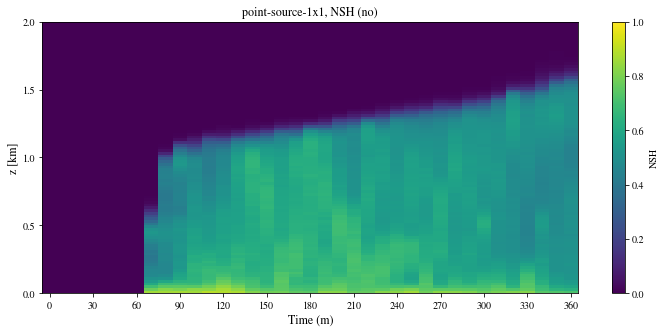

In [72]:
plotNSH(scenario='point-source-1x1', variable='no', vmin=0, vmax=1, title='')

no not in NSH dictionary for point-source-1x1, calculating
hcho not in NSH dictionary for point-source-1x1, calculating
o3 not in NSH dictionary for point-source-1x1, calculating


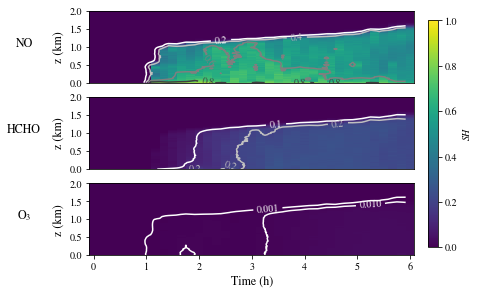

In [3]:
scenario = 'point-source-1x1'
variables = ['no', 'hcho', 'o3']
vmin = 0
vmax= 1

plotMultipleNSH(scenario, variables, vmin, vmax, xtick_delta_t=1, xtick_units='h',
                figsize=(6.5, 4.5), savefig=True)

no not in NSH dictionary for road-10x, calculating
hcho not in NSH dictionary for road-10x, calculating
o3 not in NSH dictionary for road-10x, calculating


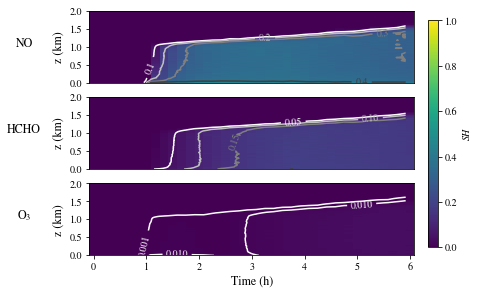

In [4]:
scenario = 'road-10x'
variables = ['no', 'hcho', 'o3']
vmin = 0
vmax= 1

plotMultipleNSH(scenario, variables, vmin, vmax, xtick_delta_t=1, xtick_units='h',
                figsize=(6.5, 4.5), savefig=True)

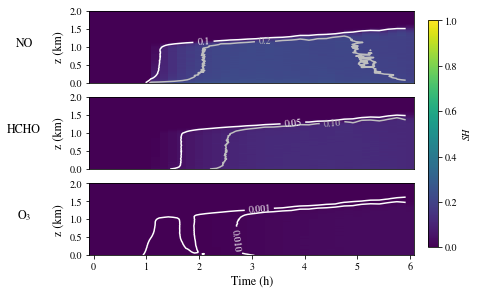

In [8]:
scenario = 'fx1fy0'
variables = ['no', 'hcho', 'o3']
vmin = 0
vmax= 1

plotMultipleNSH(scenario, variables, vmin, vmax, xtick_delta_t=1, xtick_units='h',
                figsize=(6.5, 4.5), savefig=True)

no not in NSH dictionary for uniform-basecase, calculating
hcho not in NSH dictionary for uniform-basecase, calculating
o3 not in NSH dictionary for uniform-basecase, calculating


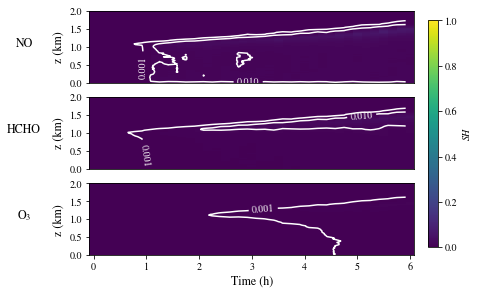

In [6]:
scenario = 'uniform-basecase'
variables = ['no', 'hcho', 'o3']
vmin = 0
vmax= 1

plotMultipleNSH(scenario, variables, vmin, vmax, xtick_delta_t=1, xtick_units='h',
                figsize=(6.5, 4.5), savefig=True)

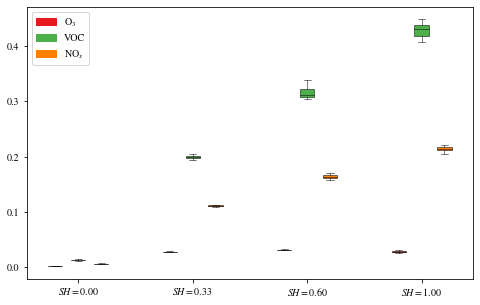

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

top_of_bl_zlevel = 55
emiss_sh_dict = Archive.getScenarioSH()
scenarios = Archive.getScenarioList()#[1:] # ignore the basecase
variables = ['o3', 'no2', 'hcho']

medianprops = dict(linestyle='-', linewidth=1, color='k')  # Customize mean line color
boxplot_width = 0.25
boxplot_data = []
#positions = []

for i, scenario in enumerate(scenarios, 1):
    for variable in variables:

        sh_timeslice = calculateNSHTimeSlice(scenario, variable, store_result=True, times=[36]) # 36 is the final timestamp at t=6hrs
        
        field_sh_data = Archive.nsh_dict[scenario][variable][0, :top_of_bl_zlevel]
        boxplot_data.append(field_sh_data)
        #positions.append(i)

# Positions for the boxplots
boxplots_per_sh_scenario = len(variables)
n_sh_scenarios = len(scenarios)
group_centers = np.linspace(1, 1+(n_sh_scenarios-1)*2, n_sh_scenarios)
positions = []
box_xdeltas = np.linspace(-.4, .4, boxplots_per_sh_scenario)
for center in group_centers:
    for xdelta in box_xdeltas:
        box_pos = center + xdelta
        positions.append(box_pos)
    
# plot boxplots
bp = ax.boxplot(boxplot_data, positions=positions, vert=True, patch_artist=True,
                    medianprops=medianprops, widths=boxplot_width, 
                    showfliers=False) # dont display outliers



# Adding colors to the boxplots
cmap_ipositions = np.linspace(0, 0.45, boxplots_per_sh_scenario)
cmap = plt.get_cmap('Set1')
counter = 0
species = ['O$_3$', 'VOC', 'NO$_x$']
legend_patches = [mpatches.Patch(color=cmap(cmap_ipos), label=label) 
                for cmap_ipos, label in zip(cmap_ipositions, species)]
for j in range(n_sh_scenarios):
    for cmap_ipos in cmap_ipositions:
        patch = bp['boxes'][counter]
        color = cmap(cmap_ipos)
        patch.set_facecolor(color)

        for component in ['boxes', 'whiskers', 'caps', 'medians', 'fliers']:
            for element in bp[component]:
                element.set_linewidth(.5)

        counter += 1

ax.set_xticks(group_centers)
ax.set_xticklabels([f"$SH={emiss_sh_dict[scenario]:3.2f}$" for scenario in scenarios])

leg = ax.legend(handles=legend_patches)
#ax.set_yscale('log')